# ***Setup ambiente con Google Drive***
Creare una cartella 'MOBD' su Google Drive e inserire al suo interno il file di training.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/MOBD

/content/drive/My Drive/MOBD


# ***Librerie***

In [3]:
import sklearn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.svm import SVC, LinearSVC
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

#serialization
from joblib import dump
from sklearn.pipeline import Pipeline
import pickle
import dill

np.random.seed = 123


# ***Lettura dataset***

Rinominare il file inserito con 'train.csv', altrimenti cambiare il nome qui sotto nel file_training.

In [4]:
file_training = "train.csv"

Il primo step consiste nella lettura del dataset e verificare che esistano valori Nan.

   F0  F1      F2  F3  F4  F5  F6  F7         F8      F9   F10  F11  F12  \
0  39  K1   77516  R1  13  Q1  P1  M1  caucasian    Male  2174    0   40   
1  50  K2   83311  R1  13  Q2  P2  M2  caucasian    Male     0    0   13   
2  38  K3  215646  R2   9  Q3  P3  M1  caucasian    Male     0    0   40   
3  53  K3  234721  R3   7  Q2  P3  M2      black    Male     0    0   40   
4  28  K3  338409  R1  13  Q2  P4  M3      black  Female     0    0   40   

    F13  Y  
0   USA  0  
1   USA  0  
2   USA  0  
3   USA  0  
4  Cuba  0  
Labels: (array([0, 1]), array([24720,  7841]))
----
# of NaNs values for each column:
F0        0
F1     1836
F2        0
F3        0
F4        0
F5        0
F6     1843
F7        0
F8        0
F9        0
F10       0
F11       0
F12       0
F13     583
Y         0
dtype: int64


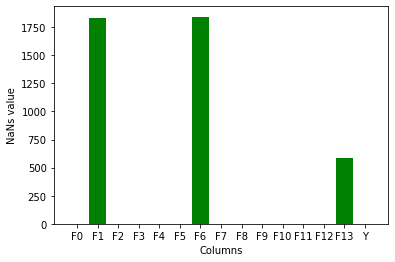

(32561, 15)


In [5]:
#Lettura del dataset
data = pd.read_csv(file_training, sep=",")
print(data.head())
print("Labels: {}".format(np.unique(data.Y, return_counts=True)))

print("----")
print("# of NaNs values for each column:")
count_nan = data.isnull().sum(axis=0)
print(count_nan )

plt.bar(data.columns, count_nan, color = "green")
plt.xlabel("Columns")
plt.ylabel("NaNs value")
plt.show()

print(data.shape)

Verifichiamo se esistono valori categorici che potrebbero essere sostituiti.

In [6]:
categorical = [print(col, data[col].unique()) for col in data.columns if data[col].dtype == "object"]

F1 ['K1' 'K2' 'K3' 'K4' 'K5' nan 'K6' 'K7' 'K8']
F3 ['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9' 'R10' 'R11' 'R12' 'R13'
 'R14' 'R15' 'R16']
F5 ['Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q7']
F6 ['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' nan 'P12' 'P13'
 'P14']
F7 ['M1' 'M2' 'M3' 'M4' 'M5' 'M6']
F8 ['caucasian' 'black' 'asian' 'american' 'other']
F9 ['Male' 'Female']
F13 ['USA' 'Cuba' 'Jamaica' 'India' nan 'Mexico' 'South' 'Puerto-Rico'
 'Honduras' 'England' 'Canada' 'Germany' 'Iran' 'Philippines' 'Italy'
 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador' 'Laos' 'Taiwan'
 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador' 'France'
 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru' 'Scotland' 'Caribbean'
 'Greece' 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Netherlands']


Per ottenere una maggiore accurattezza, vengono sostituiti nella colonna F13 i valori dei diversi Paesi al continente a cui appartengono, in modo da ottenere solo quattro diverse categorie di valori.

In [7]:
def convert(data):
  print(data['F13'].unique())
  
  asia = ["Philippines", "India", "South", "China", "Vietnam", "Japan", "Taiwan", "Iran", "Thailand", "Cambodia", "Laos", "Hong"]
  europe = ["Germany", "England", "Italy", "Poland", "Portugal", "Greece", "France", "Ireland", "Yugoslavia", "Hungary", "Scotland", "Netherlands"]
  north_america = ["USA", "Canada"]
  central_america = ["Mexico", "Puerto-Rico", "El-Salvador", "Cuba", "Jamaica", "Dominican-Republic", "Guatemala", "Haiti", "Nicaragua", "Caribbean", "Honduras"]
  south_america = ["Columbia", "Peru", "Ecuador"]
  
  data['F13'] = data['F13'].replace(asia, 'asia')
  data['F13'] = data['F13'].replace(europe, 'europe')
  data['F13'] = data['F13'].replace(north_america, 'north_america')
  data['F13'] = data['F13'].replace(south_america, 'south_america')
  data['F13'] = data['F13'].replace(central_america, 'central_america')
  
  print(data['F13'].unique())
  print(data.shape)
  
  count_F13 = data['F13'].value_counts()
  print(count_F13)
  count_F13.plot(kind="bar", color = "green")
  return data

['USA' 'Cuba' 'Jamaica' 'India' nan 'Mexico' 'South' 'Puerto-Rico'
 'Honduras' 'England' 'Canada' 'Germany' 'Iran' 'Philippines' 'Italy'
 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador' 'Laos' 'Taiwan'
 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador' 'France'
 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru' 'Scotland' 'Caribbean'
 'Greece' 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Netherlands']
['north_america' 'central_america' 'asia' nan 'europe' 'south_america']
(32561, 15)
north_america      29305
central_america     1283
asia                 751
europe               521
south_america        118
Name: F13, dtype: int64
(32561, 14)
(32561,)


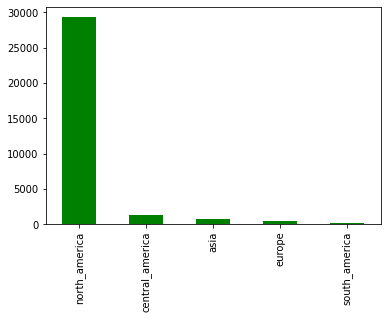

In [8]:
data = convert(data)
x = data.iloc[:, :-1]
y = data.iloc[:, -1]
print(x.shape)
print(y.shape)

# ***Training set e testing set***
Il dataset viene diviso in training set, per addestrare il modello, e testing set, per testare il modello addestrato. Suddivisione del dataset 80:20. 

In [9]:
x_tra, x_tse, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=258, stratify=y)

print(x_tra.shape)
print(y_tr.shape)
print(x_tse.shape)
print(y_ts.shape)

print(np.unique(y, return_counts=True)[1]/len(y))
print(np.unique(y_tr, return_counts=True)[1]/len(y_tr))
print(np.unique(y_ts, return_counts=True)[1]/len(y_ts))

(26048, 14)
(26048,)
(6513, 14)
(6513,)
[0.75919044 0.24080956]
[0.75917537 0.24082463]
[0.75925073 0.24074927]


# ***Preprocessing***
# **Gestione valori mancanti**
Nella fase di lettura si può vedere che le colonne F1, F6, F16 presentano dei valori categorici nan per cui è necessarrio effettuare una sostituzione attraverso SimpleInputer; la sostituzione viene fatta attraverso il valore più frequente per ogni colonna. 
Mentre le colonne che contengono valori numerici non contengono valori NaN.

# **Feature Scaling**
Tecnica utilizzata per il Feature Scaling è RobustScaler per la gestione degli outliers.
# **One Hot Encoder**
I valori categori non possono essere usati, per questo motivo attraverso la One Hot Encoder possiamo sostituire questi valori con dei valori numerici ognuno dei quali corrisponde ad un determinato valore.
Per esempio, nella colonna F9 avremo:
*   Male | 0
*   Female | 1


In [10]:
def transformer(x_set):
  #salviamo in due liste diverse le colonne che contengono valori numerici e categorici
  numerical_columns = [col for col in x_set.columns if x_set[col].dtype in ["int64", "float64"]]
  categorical_columns = [col for col in x_set.columns if x_set[col].dtype == "object"]

  #attraverso la Pipeline eseguiamo una serie di azioni
  #applichiamo SimpleImputer per sostituire i valori Nan attraverso la media e applichiamo feature scaling
  numerical_transformer = Pipeline(steps=[
                                          ("imputer", SimpleImputer(strategy="mean")),
                                          ("scaler", RobustScaler())
                                            ])
  #applichiamo SimpleImputer per sostituire i valori Nan attraverso valori più frequenti e applichiamo oneHotEncoder per trasformare
  #i valori categorici in valori numerici ognuno dei quali viene assegnato un valore [0.1] in base al valore categorico
  categorical_transformer = Pipeline(steps=[
                                            ("imputer", SimpleImputer(strategy="most_frequent")),
                                            ("ohe", OneHotEncoder(handle_unknown="ignore"))
                                            ])
  #consente di applicare una sequenza di trasformazioni solo alle colonne numeriche e una sequenza separata di trasformazioni solo alle colonne categoriali
  preprocessor = ColumnTransformer(
       transformers=[
                      ('numerical', numerical_transformer, numerical_columns),
                      ('categorical', categorical_transformer, categorical_columns)],
                      remainder='passthrough')
  return preprocessor

preprocessor = transformer(x)
x_tr= preprocessor.fit_transform(x_tra)
x_ts= preprocessor.transform(x_tse)

y_tr=pd.DataFrame(y_tr)

# **Bilanciamento del dataset**
Bilanciamento del dataset necessario oichè le due classi non sono bilanciate, viene utilizzato la tecninca dell'oversampling con SMOTE.

Size del dataset prima del sampler: 26048
Size del dataset dopo il sampler: 39551


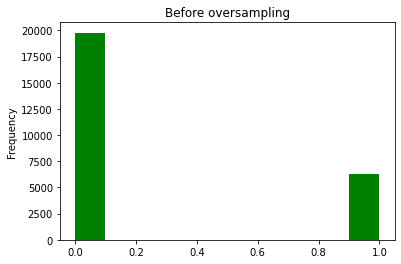

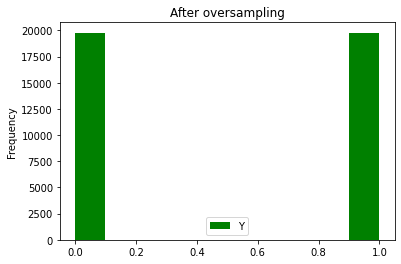

In [11]:
# BALANCING OVERSAMPLING
#prima di effetturare oversapling notiamo una classe maggioritaria
y_tr['Y'].plot(kind="hist", title = 'Before oversampling', color = "green")

#Smote
sampler = KMeansSMOTE(random_state = 0, sampling_strategy = 'not majority', k_neighbors = 10, n_jobs = -1)
x_tr_balanced_ov, y_tr_balanced_ov = sampler.fit_resample(x_tr, y_tr.values.ravel())

print("Size del dataset prima del sampler: {}".format(x_tr.shape[0]))
print("Size del dataset dopo il sampler: {}".format(x_tr_balanced_ov.shape[0]))

#dopo oversampling le due classi sono bilanciate
pd.DataFrame(y_tr_balanced_ov, columns = ['Y']).plot(kind='hist', title = 'After oversampling', color = "green")


# **Anomaly detection**
dopo aver fatto oversamping, dato che vengono aggiunti mlto campioni per poter bilanciare il dataset, potrebbero risultare delle anomalie che comporterebbe un peggiorare delle prestazioni. Per questo motivo, con anomaly detection andiamo ad eliminare le righe che causano rumore.

ANOMALY DETECTION CON ISOLATION FOREST AFTER OVERSAMPLING
Initial distribution
26048
[0.75917537 0.24082463]
(array([-1,  1]), array([  312, 39239]))
Distribution after balancing
39551
[0.49998736 0.50001264]
Distribution after anomaly detection
39239
[0.49861108 0.50138892]


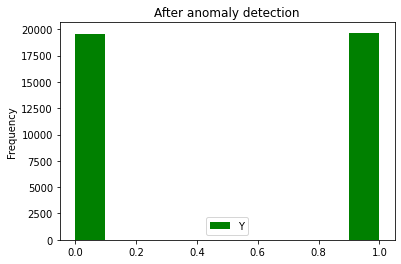

In [12]:
# ANOMALY DETECTION CON ISOLATION FOREST AFTER OVERSAMPLING
print("ANOMALY DETECTION CON ISOLATION FOREST AFTER OVERSAMPLING")
print("Initial distribution")
print(x_tr.shape[0])
print(np.unique(y_tr, return_counts=True)[1]/len(y_tr))

anomaly_detector_ov = IsolationForest()
anomaly_detector_ov.fit(x_tr_balanced_ov)
is_inlier_ov = anomaly_detector_ov.predict(x_tr_balanced_ov)

print(np.unique(is_inlier_ov, return_counts=True))
x_tr_not_anomalous_ov = x_tr_balanced_ov[is_inlier_ov==1,:]
y_tr_not_anomalous_ov = y_tr_balanced_ov[is_inlier_ov==1]

print("Distribution after balancing")
print(x_tr_balanced_ov.shape[0])
print(np.unique(y_tr_balanced_ov, return_counts=True)[1]/len(y_tr_balanced_ov))

print("Distribution after anomaly detection")
print(x_tr_not_anomalous_ov.shape[0])
print(np.unique(y_tr_not_anomalous_ov, return_counts=True)[1]/len(y_tr_not_anomalous_ov))

pd.DataFrame(y_tr_not_anomalous_ov, columns = ['Y']).plot(kind='hist', title = 'After anomaly detection', color = "green")

# **Classificatore**
Dopo diversi tentativi con diversi classificatori, il miglior risultato è stato ottenuto con GradientBoostingClassifier.

In [13]:
def train_evaluate(model, x_tr, y_tr, x_ts, y_ts):
  model.fit(x_tr, y_tr)
  y_tr_pred = model.predict(x_tr)
  y_ts_pred = model.predict(x_ts)

  print("Accuracy on training set {}".format(accuracy_score(y_tr, y_tr_pred)))
  print("F1 score on training set {}".format(f1_score(y_tr, y_tr_pred)))
  conf_matrix = confusion_matrix(y_tr, y_tr_pred)
  print(conf_matrix)
  ConfusionMatrixDisplay(conf_matrix).plot(cmap = 'Greens')

  print("Accuracy on test set {}".format(accuracy_score(y_ts, y_ts_pred)))
  print("F1 score on test set {}".format(f1_score(y_ts, y_ts_pred)))
  conf_matrix = confusion_matrix(y_ts, y_ts_pred)
  print(conf_matrix)
  ConfusionMatrixDisplay(conf_matrix).plot(cmap = 'Greens')

In [14]:
# Classificatore GradientBoostingClassifier
classifierGBC = GradientBoostingClassifier()

grid = dict()

grid['n_estimators'] =  np.arange(100, 250, 1000)
grid['learning_rate'] = [.1, 0.5, 1.0]
grid['max_depth'] = [2, 3, 5]

# K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

# Grid Search
grid_search = GridSearchCV(estimator = classifierGBC, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
grid_fit = grid_search.fit(x_tr_not_anomalous_ov, y_tr_not_anomalous_ov)

# Miglior modello
print("Best: %f using %s" % (grid_fit.best_score_ , grid_fit.best_params_))

Best: 0.915518 using {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [15]:
# Classificatore AdaBoostClassifier
classifierADA = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

grid = dict()

grid['n_estimators'] =  np.arange(100, 250, 1000)
grid['learning_rate'] = [.1, 0.5, 1.0]
grid['base_estimator__max_depth'] = [2, 3, 5]

# K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

# Grid Search
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
grid_fit = grid_search.fit(x_tr_not_anomalous_ov, y_tr_not_anomalous_ov)

# Miglior modello
print("Best: %f using %s" % (grid_fit.best_score_ , grid_fit.best_params_))

Best: 0.914830 using {'base_estimator__max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 100}


In [ ]:
# Classificatore RandomForestClassifier
classifierRFC = RandomForestClassifier()
grid = dict()

grid['n_estimators'] =  np.arange(100, 250, 1000)
grid['max_depth'] = [2, 5, 10]

# K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

#  Grid Search
grid_search = GridSearchCV(estimator = classifierRFC, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
grid_fit = grid_search.fit(x_tr_not_anomalous_ov, y_tr_not_anomalous_ov)

# Miglior modello
print("Best: %f using %s" % (grid_fit.best_score_ , grid_fit.best_params_))

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Best: 0.905480 using {'max_depth': 10, 'n_estimators': 100}


In [ ]:
# Classificatore SVC
classifierSVC = SVC()

grid = dict()

grid['kernel'] =  ['rbf', 'sigmoid']
grid['C'] = [.1, 1, 10]
grid['gamma'] = ['scale']

# K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

# Grid Search
grid_search = GridSearchCV(estimator = classifierSVC, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
grid_fit = grid_search.fit(x_tr_not_anomalous_ov, y_tr_not_anomalous_ov)

# Miglior modello
print("Best: %f using %s" % (grid_fit.best_score_ , grid_fit.best_params_))

Best: 0.871055 using {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Classificatore DecisionTreeClassifier
classifierDTC = DecisionTreeClassifier()

grid = dict()

grid['criterion'] =  ['gini', 'entropy']
grid['max_depth'] = [2, 5, 10, 30]
grid['splitter'] = ['best', 'random']

# K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

# Grid Search
grid_search = GridSearchCV(estimator = classifierDTC, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
grid_fit = grid_search.fit(x_tr_not_anomalous_ov, y_tr_not_anomalous_ov)

# Miglior modello
print("Best: %f using %s" % (grid_fit.best_score_ , grid_fit.best_params_))

Best: 0.905964 using {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}


Accuracy on training set 0.9212882873715275
F1 score on training set 0.9194857916102842
[[18547  1050]
 [ 2044 17667]]
Accuracy on test set 0.8721019499462613
F1 score on test set 0.714236706689537
[[4639  306]
 [ 527 1041]]


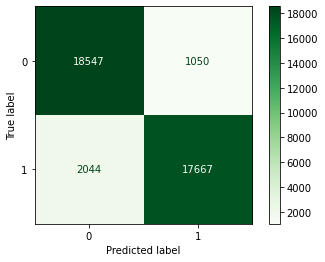

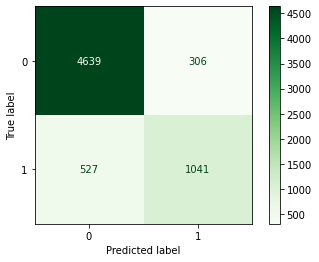

In [ ]:
# Miglior classificatore
classificator = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, loss='exponential', max_depth=5, random_state=0)
train_evaluate(classificator, x_tr_not_anomalous_ov, y_tr_not_anomalous_ov, x_ts, y_ts)

Accuracy on training set 0.9184135544927241
F1 score on training set 0.9165256773992034
[[18495  1102]
 [ 2105 17606]]
Accuracy on test set 0.8724090280976509
F1 score on test set 0.7162854216456129
[[4633  312]
 [ 519 1049]]


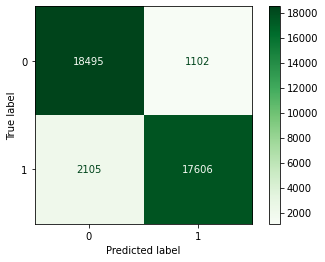

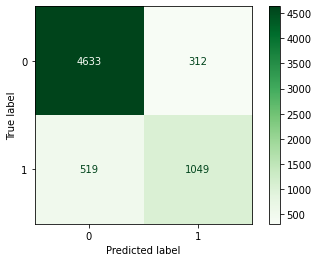

In [ ]:
classificator = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), n_estimators=100, learning_rate=0.5, random_state=0)
train_evaluate(classificator, x_tr_not_anomalous_ov, y_tr_not_anomalous_ov, x_ts, y_ts)

# **Serializzazione dati**
Salviamo i dati serializzati che serviranno per la fase di testing. Comprende la serializzazione:

*   classificatore utilizzato
*   fase di prepocessing, che comprende: gestione dei valori mancanti, feature scaling, OneHotEncoder



In [ ]:
dump(classificator, 'classificator.joblib') 
dump(preprocessor, 'preprocessing.joblib')

['preprocessing.joblib']